# Mid-term Project for BDAI

首先，读取原始数据并且作出原始数据的图像

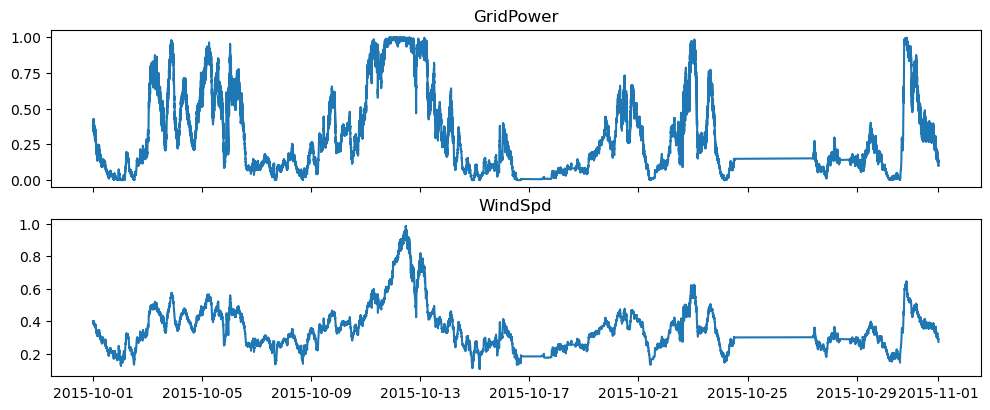

In [1]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# IMPORT DATA
wind = pd.read_csv(
    "E:/学习资料/2022-2023 Semester 1/Big Data And Artifitial Intelligence/data/wind.csv", parse_dates=['DateAcqTime'])

# PLOT THE DATA
plt.subplots(2,1,figsize=(12,4.5),sharex=True)

plt.subplot(2,1,1)
plt.plot(wind.DateAcqTime, wind.GridPower)
plt.gca().set(title="GridPower")

plt.subplot(2,1,2)
plt.plot(wind.DateAcqTime, wind.wind_Spd)
plt.gca().set(title="WindSpd")
plt.show()

从以上图中可以发现明显的数据具有缺失值的现象；并且图中的点数量过多，对预测4个15分钟构成的点存在困难。同时信号噪音较大，造成了很严重的毛刺现象。下面对数据进行清洗和预处理，试图解决下列问题。

## 数据清洗与预处理

### 减少数据点数量

下面按照国家标准要求，将所得每秒两个点的风能数据以15分钟为一个单位进行求和，得到数据点数量大为减少后方便后续分析使用的数据。

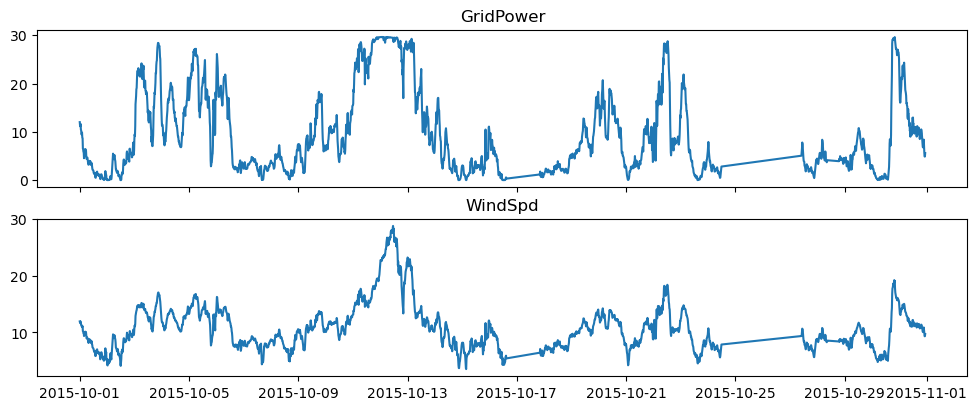

In [71]:
# 第一部分从10.1到10/16下午14点，以15min为一个中间点
Gridpower_hour1 = np.zeros(15*24*4+15*4)
windspd_hour1 = np.zeros(15*24*4+15*4)
for i in range(15*24*4+15*4):
    for j in range(30):
        Gridpower_hour1[i] += wind.GridPower[30*i+j]
        windspd_hour1[i] += wind.wind_Spd[30*i+j]
Date_hour1 = []
starttime1 = datetime(2015, 10, 1, 0, 0, 0)
for i in range(15*24*4+15*4):
    ti = starttime1+timedelta(minutes=i*15)
    Date_hour1.append(ti)
Date_hour1 = np.array(Date_hour1)
# 第二部分从10/17 20:00到10/24 11:00
Gridpower_hour2 = np.zeros(7*24*4-8*4)
windspd_hour2 = np.zeros(7*24*4-8*4)
for i in range(7*24*4-8*4):
    for j in range(30):
        Gridpower_hour2[i] += wind.GridPower[45069+30*i+j]
        windspd_hour2[i] += wind.wind_Spd[45069+30*i+j]
Date_hour2 = []
starttime2 = datetime(2015, 10, 17, 20, 0, 0)
for i in range(7*24*4-8*4):
    ti = starttime2+timedelta(minutes=i*15)
    Date_hour2.append(ti)
Date_hour2 = np.array(Date_hour2)
# 第三部分从10/27 10:00到10/28 8:00
Gridpower_hour3 = np.zeros(24*4-1*4)
windspd_hour3 = np.zeros(24*4-1*4)
for i in range(24*4-1*4):
    for j in range(30):
        Gridpower_hour3[i] += wind.GridPower[62757+30*i+j]
        windspd_hour3[i] += wind.wind_Spd[62757+30*i+j]
Date_hour3 = []
starttime3 = datetime(2015, 10, 27, 10, 0, 0)
for i in range(24*4-1*4):
    ti = starttime3+timedelta(minutes=i*15)
    Date_hour3.append(ti)
Date_hour3 = np.array(Date_hour3)
# 第四部分从10/28 19:00到10/31 23:00
Gridpower_hour4 = np.zeros(3*24*4+4*4)
windspd_hour4 = np.zeros(3*24*4+4*4)
for i in range(3*24*4+4*4):
    for j in range(30):
        Gridpower_hour4[i] += wind.GridPower[65642+30*i+j]
        windspd_hour4[i] += wind.wind_Spd[65642+30*i+j]
Date_hour4 = []
starttime4 = datetime(2015, 10, 28, 19, 0, 0)
for i in range(3*24*4+4*4):
    ti = starttime4+timedelta(minutes=i*15)
    Date_hour4.append(ti)
Date_hour4 = np.array(Date_hour4)
# 合并成新的数据
Date_hour = np.concatenate(
    (Date_hour1, Date_hour2, Date_hour3, Date_hour4), axis=0)
Gridpower_hour = np.concatenate(
    (Gridpower_hour1, Gridpower_hour2, Gridpower_hour3, Gridpower_hour4), axis=0)
windspd_hour = np.concatenate(
    (windspd_hour1, windspd_hour2, windspd_hour3, windspd_hour4), axis=0)
wind_hour = pd.DataFrame(
    np.array([Date_hour, Gridpower_hour, windspd_hour]).transpose())
wind_hour.columns = ["DateAcqTime", "GridPower", "wind_Spd"]

# 重新进行画图
plt.subplots(2,1,sharex=True,figsize=(12,4.5))

plt.subplot(2,1,1)
plt.plot(wind_hour.DateAcqTime, wind_hour.GridPower)
plt.gca().set(title="GridPower")

plt.subplot(2,1,2)
plt.plot(wind_hour.DateAcqTime, wind_hour.wind_Spd)
plt.gca().set(title="WindSpd")
plt.show()

可以发现，数据变得更加平滑，在后续的预测过程中，只需要增加4个点即可。

### 数据填补

由于存在数据缺失的现象，下面通过pandas库中的fillna函数，通过ffill方法，即取缺失值前和后最近点的均值进行数据的填补。

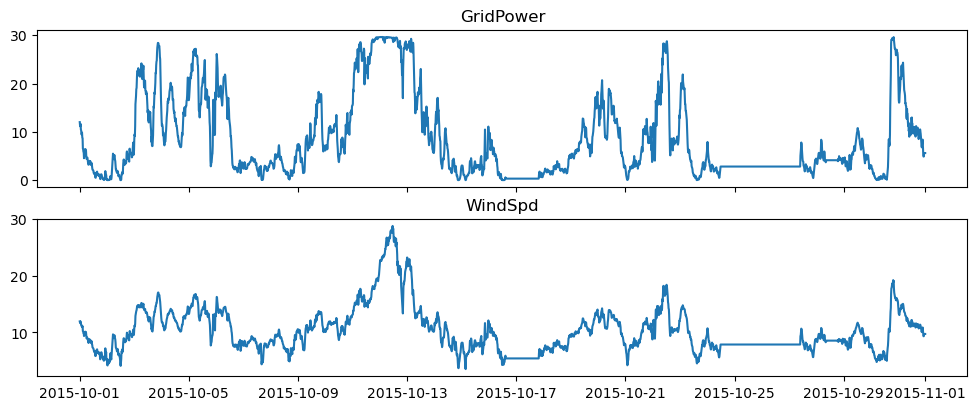

In [72]:
# 进行数据填补
Date = []
GridPower = np.zeros(31*24*4)
WindSpd = np.zeros(31*24*4)
starttime = datetime(2015, 10, 1, 0, 0, 0)
for i in range(31*24*4):
    ti = starttime1+timedelta(minutes=i*15)
    if ti in Date_hour:
        idx = np.argwhere(Date_hour == ti)
        GridPower[i] = Gridpower_hour[idx]
        WindSpd[i] = windspd_hour[idx]
    else:
        GridPower[i] = np.nan
        WindSpd[i] = np.nan
    Date.append(ti)
Date = np.array(Date)

## IMPUTATION
data_pre = np.vstack((Date,GridPower,WindSpd)).T
data_df = pd.DataFrame(data_pre,columns=["Date","GridPower","WindSpd"])
data_df = data_df.fillna(method="ffill")
data_df.GridPower = np.array(data_df["GridPower"])
data_df.WindSpd = np.array(data_df["WindSpd"])

# 重新进行画图
plt.subplots(2,1,figsize=(12,4.5),sharex=True)

plt.subplot(2,1,1)
plt.plot(data_df.Date, data_df.GridPower)
plt.gca().set(title="GridPower")

plt.subplot(2,1,2)
plt.plot(data_df.Date, data_df.WindSpd)
plt.gca().set(title="WindSpd")
plt.show()

可以发现，实际上填补的效果并不好，在后续进行学习分析的时候，需要尽可能避开填补的点，通过分段进行拟合。

### 数据平滑

采用Moving Average的方法对数据进行平滑，消除噪声的影响。同时由于Moving Average只是取了临近点的均值，因此尽可能的保留了原来数据的统计信息，也方便后续进行分析。

经过多次尝试后之后，选择利用20个数据点取平均进行平滑。在这种情况下，数据的毛刺消失得较为明显，同时又保留了较多的峰和谷的信息，为后续的分析提供更多的信息量。

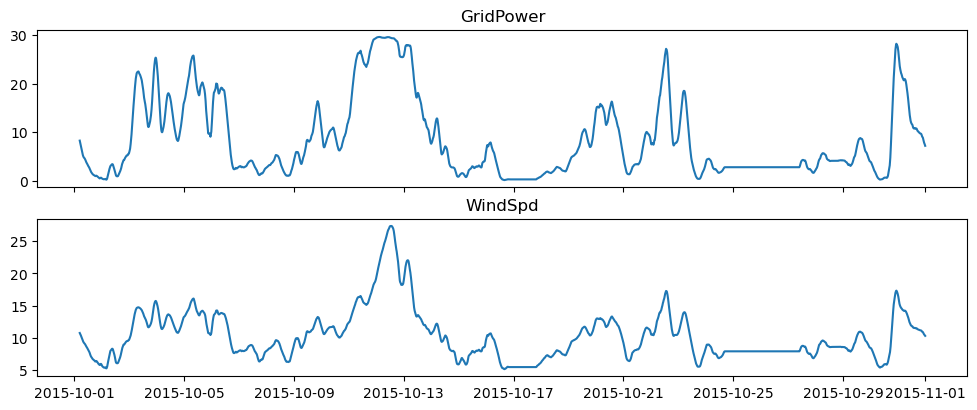

In [73]:
## 平滑方法 采用MA
data_df["GridPower_ma"] = data_df["GridPower"].rolling(20).mean()
data_df["WindSpd_ma"] = data_df["WindSpd"].rolling(20).mean()
GridPower_ma = data_df.GridPower_ma
WindSpd_ma = data_df.WindSpd_ma

# 重新进行画图
plt.subplots(2,1,figsize=(12,4.5),sharex=True)

plt.subplot(2,1,1)
plt.plot(Date, GridPower_ma)
plt.gca().set(title="GridPower")

plt.subplot(2,1,2)
plt.plot(Date, WindSpd_ma)
plt.gca().set(title="WindSpd")
plt.show()

在进行平滑后仍可以发现填补的数据较为明显得与其他部分的数据规律不同，因此确实应该尽量避免对缺失部分进行学习。

在后续的分析中，由于处于EDA的状况，尽量采用所有的信息量，因此选择不使用平滑后的数据进行分析。

## 数据统计特性的描述和分析

### 进行位置与变异性估计

首先，分别作出GridPower和WindSpd的分布图，求出两组数据的均值与中位数与方差，在近似正态性下得到其置信区间，并画在时间序列图中。

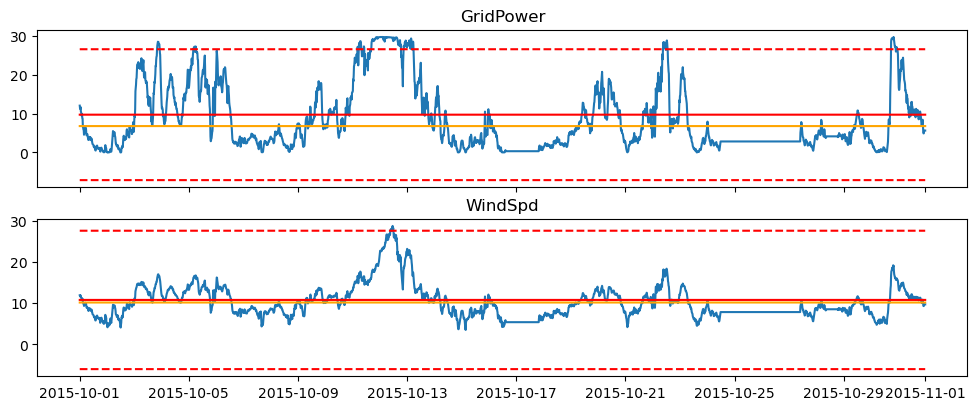

In [74]:
GridPower_mean = np.mean(wind_hour.GridPower)
WindSpd_mean = np.mean(wind_hour.wind_Spd)
GridPower_median = np.median(wind_hour.GridPower)
WindSpd_median = np.median(wind_hour.wind_Spd)
GridPower_se = np.var(wind_hour.GridPower)**(1/2)
WindSpd_se = np.var(wind_hour.wind_Spd)**(1/2)
GridPower_d = GridPower_mean-1.96*GridPower_se
GridPower_u = GridPower_mean+1.96*GridPower_se
WindSpd_d = WindSpd_mean - 1.96*GridPower_se
WindSpd_u = WindSpd_mean + 1.96*GridPower_se

# 重新进行画图
plt.subplots(2,1,figsize = (12,4.5),sharex=True)

plt.subplot(2,1,1)
plt.plot(data_df.Date, data_df.GridPower)
plt.plot(data_df.Date, GridPower_mean*np.ones(len(data_df.Date)), color="red")
plt.plot(data_df.Date, GridPower_median*np.ones(len(data_df.Date)), color="orange")
plt.plot(data_df.Date, GridPower_u*np.ones(len(data_df.Date)), color="red", linestyle='--')
plt.plot(data_df.Date, GridPower_d*np.ones(len(data_df.Date)), color="red", linestyle='--')
plt.gca().set(title="GridPower")

plt.subplot(2,1,2)
plt.plot(data_df.Date, data_df.WindSpd)
plt.plot(data_df.Date, WindSpd_mean*np.ones(len(data_df.Date)), color="red")
plt.plot(data_df.Date, WindSpd_median*np.ones(len(data_df.Date)), color="orange")
plt.plot(data_df.Date, WindSpd_u*np.ones(len(data_df.Date)), color="red", linestyle='--')
plt.plot(data_df.Date, WindSpd_d*np.ones(len(data_df.Date)), color="red", linestyle='--')
plt.gca().set(title="WindSpd")
plt.show()

可以发现，对于GridPower数据，均值与中位数有一定的差异；而在WindSpd数据中，均值与中位数的差异较小。但从置信区间中可以看出，在同分布正态性假设下，数据存在较少的离群值，而均值具有无偏性且微分性质良好等特征，因此在之后的统计分析中，可以利用均值作为数据统计分析的基础。

### 作出数据直方图

下面作出GridPower和WindSpd的直方图，并且得到它们的kernal density estimation图。

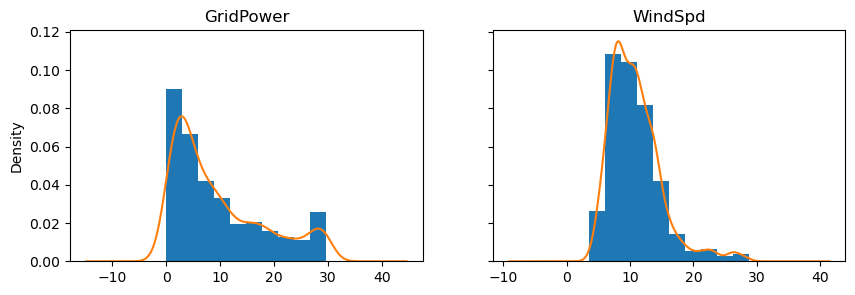

In [75]:
# 画出histogram
plt.subplots(1,2,figsize=(10,3),sharey=True)

plt.subplot(1,2,1)
plt.hist(wind_hour.GridPower,density=True)
wind_hour.GridPower.plot.density()
plt.title("GridPower")

plt.subplot(1,2,2)
plt.hist(wind_hour.wind_Spd,density=True)
wind_hour.wind_Spd.plot.density()
plt.title("WindSpd")
plt.show()

可以发现两组数据都是有较为明显的右偏特征的数据，近似正态性特征较差。同时GridPower具有双峰的特征，因此可能处理起来较为困难。并且由于数据截断的特征，导致边缘处的正态拟合表现不佳。

### 相关性分析

求出两组数据间的相关性如下：

In [76]:
print(data_df.corr())

              GridPower   WindSpd  GridPower_ma  WindSpd_ma
GridPower      1.000000  0.951346      0.928709    0.892089
WindSpd        0.951346  1.000000      0.903018    0.942354
GridPower_ma   0.928709  0.903018      1.000000    0.956864
WindSpd_ma     0.892089  0.942354      0.956864    1.000000


可以发现两组数据间的线性相关性非常显著，提示我们后续可能可以利用线性回归的方法对两组数据之间的关系进行分析。

## 特征提取

接下来对风能数据进行特征提取，首先考虑WindSpd与GridPower之间的关系，同时通过Kernel Regression，一种无监督的回归方法，探究GridPower和WindSpd之间的关系。

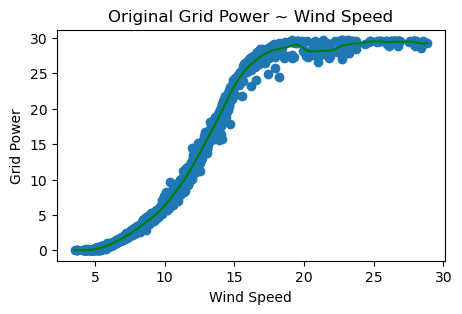

In [77]:
from statsmodels.nonparametric.kernel_regression import KernelReg

# 画出scatter plot 并作出smooth line
smooth1 = KernelReg(endog=Gridpower_hour,exog=windspd_hour,var_type="c")
xws = np.linspace(np.min(wind_hour.wind_Spd),np.max(wind_hour.wind_Spd),10000)
ygp,ygp_std = smooth1.fit(xws)
plt.figure(figsize=(5, 3))
plt.scatter(wind_hour.wind_Spd,wind_hour.GridPower)
plt.plot(xws,ygp,color="green")
plt.title("Original Grid Power ~ Wind Speed")
plt.xlabel("Wind Speed")
plt.ylabel("Grid Power")
plt.show()

### Logistic Regression
由图可以发现，似乎可以利用Logistic Regression等Generalized Linear Regression对二者的关系进行建模研究，因此以下建立Logistic Regression关系，并作出拟合值与观测值之间关系的图像。

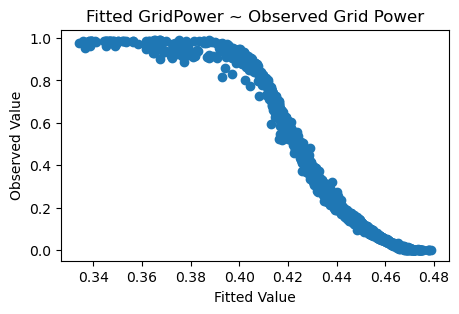

In [78]:
import statsmodels.api as sm

## USING LOGISTIC REGRESSION TO PLOT ORIGINAL DATA
Gridpower_hour1 = Gridpower_hour/30
glm_binom = sm.GLM(Gridpower_hour1,windspd_hour,family=sm.families.Binomial())

# 画出scatter plot 并作出smooth line
res = glm_binom.fit()
plt.figure(figsize=(5,3))
plt.scatter(res.mu,Gridpower_hour1)
plt.title("Fitted GridPower ~ Observed Grid Power")
plt.xlabel("Fitted Value")
plt.ylabel("Observed Value")
plt.show()

由于求和后GridPower的值不再为1，在直接进行压缩变换后效果仍不理想，可以发现Fitted Value和Observed Value有较大的差异，因此采用逻辑回归模型对二者的关系进行探究是不可行的。

接下来，考虑是否可以通过一定的变换，将非线性的关系转化为线性的关系。在此处选用在Linear Regression模型中常用的BoxCox变换给出能够使模型最趋近于线性化的变换。

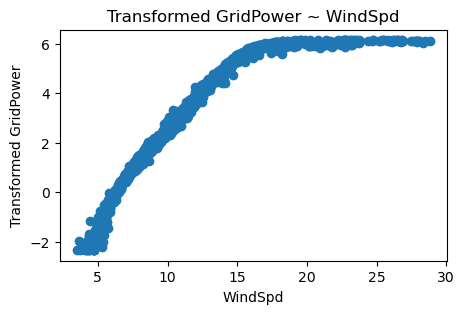

In [79]:
from scipy import stats

# 尝试通过变换变成linear relationship
fitted_data, fitted_lambda = stats.boxcox(Gridpower_hour)
plt.figure(figsize=(5,3))
plt.scatter(wind_hour.wind_Spd,fitted_data)
plt.xlabel("WindSpd")
plt.ylabel("Transformed GridPower")
plt.title("Transformed GridPower ~ WindSpd")
plt.show()

由图可以发现难以通过BoxCox变换直接得到线性关系，猜测是由于非线性的转折过于强，因此考虑分段进行线性回归。但考虑到解释性原因，首先查看BoxCox变换让AIC最优得到的幂变换值，从而考虑其最接近的、能表现出强线性关系的、具有良好解释性的幂变换值进行研究。

In [80]:
##可以发现难以变成线性关系
print(fitted_lambda)

0.32219054795033736


因此，在分别考察log变换和开根号变换后GridPower的线性化成都后，决定采用开根号的GridPower进行分段线性回归。粗略地认为拐点位于WindSpd=16.5处。

在以下模型中，由于一开始采用Log变换进行书写，因此变量名可能产生歧义，请以文字中描述为准。

首先得到在16.5前的线性模型，可以得到其相关的信息如下表。

In [81]:
import statsmodels.api as sm

##尝试开根数据之后进行分段线性回归
logGridPower = np.power(Gridpower_hour,0.5)

##找到拐点，认为拐点在17左右
idx = np.where(wind_hour.wind_Spd[1:]<=16.5)
##First Linear Regression
logGridPower1 = logGridPower[idx]
Windspd = np.array(wind_hour.wind_Spd[1:])
Windspd1 = Windspd[idx]
logGridPower1 = np.array(logGridPower1,dtype=float)
Windspd1 = np.array(Windspd1,dtype=float)
one1 = np.ones(len(Windspd1))
X1 = np.vstack((one1,Windspd1)).T
reg1 = sm.OLS(logGridPower1,X1)
res1 = reg1.fit()
print(res1.summary())
beta1 = res1.params

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                 9.500e+04
Date:                Fri, 18 Nov 2022   Prob (F-statistic):               0.00
Time:                        15:19:43   Log-Likelihood:                 542.72
No. Observations:                2342   AIC:                            -1081.
Df Residuals:                    2340   BIC:                            -1070.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.7485      0.015   -119.942      0.0

由表可以发现，其$R^2$非常接近1，同时P-Value，AIC等指标表现优异，可以认为这线性关系非常强。
同理得到第二部分线性模型的相关信息如下表：

In [82]:
##Second Linear Regression
idx2 = np.where(wind_hour.wind_Spd[1:]>16.5)
logGridPower2 = np.array(logGridPower[idx2],dtype=float)
Windspd2 = np.array(Windspd[idx2],dtype=float)
one2 = np.ones(len(Windspd2))
X2 = np.vstack((one2,Windspd2)).T
reg2 = sm.OLS(logGridPower2,X2)
res2 = reg2.fit()
print(res2.summary())
beta2 = res2.params

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     76.91
Date:                Fri, 18 Nov 2022   Prob (F-statistic):           9.83e-16
Time:                        15:19:44   Log-Likelihood:                 163.33
No. Observations:                 193   AIC:                            -322.7
Df Residuals:                     191   BIC:                            -316.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9484      0.045    111.132      0.0

虽然在本表中，$R^2$表现得不佳，但是P-Value仍然仍然表现得较为显著，同时通过作图可以发现其线性关系还是非常显著的，因此认为本模型可行。$R^2$小可能是由于样本点较少造成。
接下来对变换数据与拟合出的线性模型进行画图，直观检验拟合的效果如何。

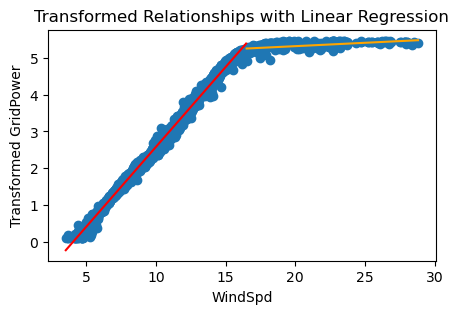

In [83]:
plt.figure(figsize=(5,3))
plt.scatter(wind_hour.wind_Spd,logGridPower)
x = np.linspace(np.min(Windspd1),np.max(Windspd1),1000)
y = beta1[0]+beta1[1]*x
plt.plot(x,y,color="red")
x2 = np.linspace(np.min(Windspd2),np.max(Windspd2),1000)
y2 = beta2[0]+beta2[1]*x2
plt.plot(x2,y2,color="orange")
plt.xlabel("WindSpd")
plt.ylabel("Transformed GridPower")
plt.title("Transformed Relationships with Linear Regression")
plt.show()

由图可发现，本线性回归模型拟合效果良好，在后续可以利用传统的时间序列分析的方法对GridPower的值进行预测。

### 时间序列的特征提取
在时间序列的分析中，由于后续将会采用smooth后的数据进行研究，因此采用smooth后的数据进行本部分的特征提取

#### 时间序列的稳定性分析

首先进行ADF Test，说明两个序列均不为白噪音

In [84]:
from statsmodels.tsa.stattools import adfuller as ADF

GridPower_ma = GridPower_ma[19:]
WindSpd_ma = WindSpd_ma[19:]

adft_GridPower = ADF(GridPower_ma)
## show P-Value
print(adft_GridPower[1])

adft_WindSpd = ADF(WindSpd_ma)
print(adft_WindSpd[1])

0.006316769998208343
0.010943397884897003


可以得到两个P-Value均小于0.05，可以说明两个序列本身就近似为白噪音，即用传统的Time Series Analysis方法会较为难以获得结果；当然，其P-Value不特别小，如果使用ARIMA model进行fit的话，仍可能有一定的拟合效果。

通过一次差分可以发现在一次差分后，其平稳性大大增强了，这提示我们如果使用ARIMA模型的话，系数一般不会超过1，这给予了模型很强的鲁棒性和计算的便利性。

In [85]:
GridPower_diff1 = GridPower_ma.diff()
WindSpd_diff1 = WindSpd_ma.diff()

adft_GridPower_diff1 = ADF(GridPower_diff1[1:])
print(adft_GridPower_diff1[1])
adft_WindSpd_diff1 = ADF(WindSpd_diff1[1:])
print(adft_WindSpd_diff1[1])

9.729867465679e-16
2.7117316155290392e-14


#### 自相关性探究

下面可以作出两个序列的自相关性和偏自相关性图像，初步探究其ARIMA模型的参数。

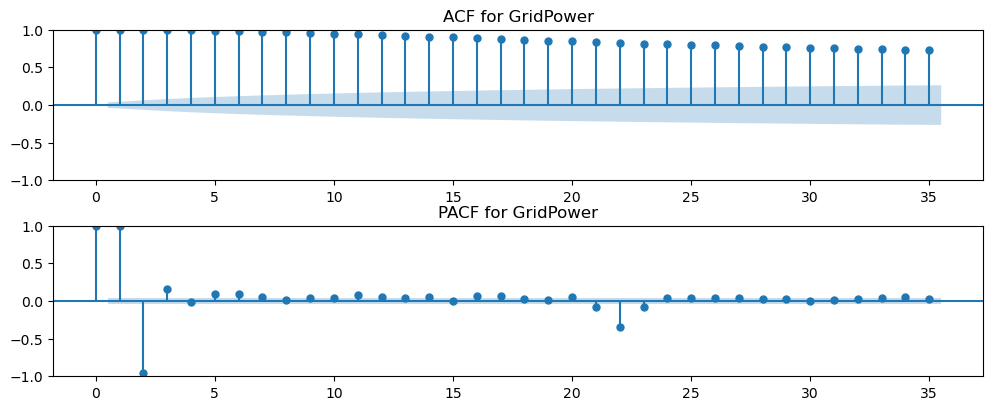

In [86]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig1,ax1 = plt.subplots(2,1,figsize=(12,4.5))
plt.subplots_adjust(hspace=0.30)
plot_acf(GridPower_ma,ax=ax1[0])
ax1[0].set_title("ACF for GridPower")
plot_pacf(GridPower_ma,method="ywm",ax=ax1[1])
ax1[1].set_title("PACF for GridPower")
plt.show()

可以发现自回归系数非常显著，而偏相关系数只有几项显著，因此对于GridPower而言，更加贴近于MA模型。

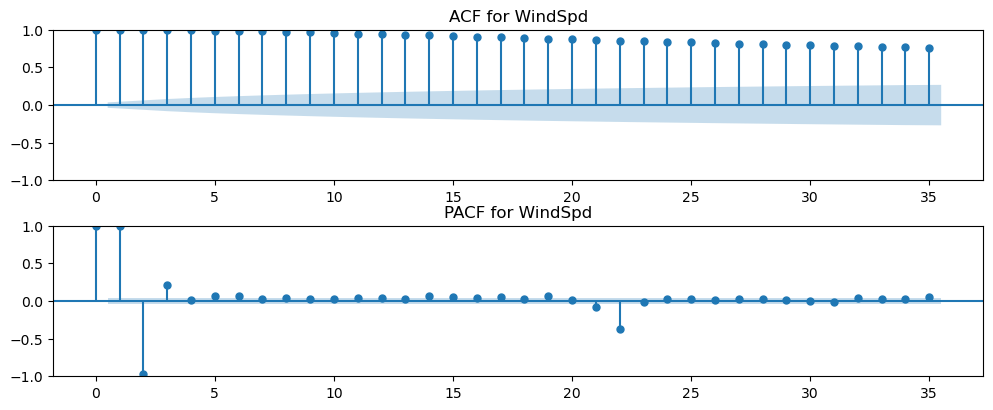

In [87]:
fig2,ax2 = plt.subplots(2,1,figsize=(12,4.5))
plt.subplots_adjust(hspace=0.30)
plot_acf(WindSpd_ma,ax=ax2[0])
ax2[0].set_title("ACF for WindSpd")
plot_pacf(WindSpd_ma,method="ywm",ax=ax2[1])
ax2[1].set_title("PACF for WindSpd")
plt.show()

对于WindSpd而言，情况也是相似的，二者的ACF与PACF也有一定的相似性，说明二者之间有一定显著的相关关系。

### Fourier Transform
下面对两组数据进行Fourier Transform，查看我们所得到的时序序列的频域特征。
由于为15min取一个点，总共有31天的数据，因此可以得到相应的sample rate和Duration。

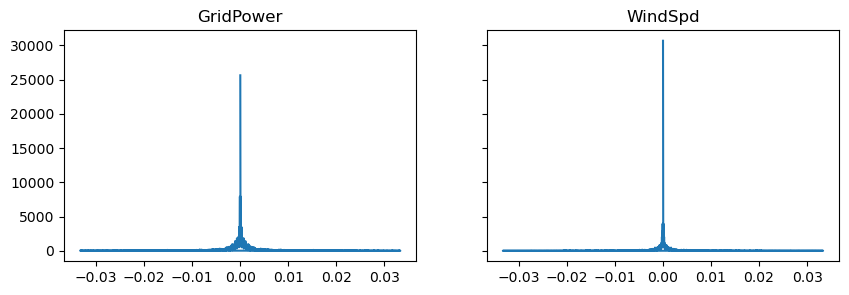

In [88]:
from scipy.fft import fft, fftfreq

##Initial Value
sr = 1/15
duration = 31*24*60
tot_num = int(sr*duration)

GridPower_fft = fft(np.array(data_df.GridPower))
WindSpd_fft = fft(np.array(data_df.WindSpd))
xf = fftfreq(tot_num,1/sr)

plt.subplots(1,2,figsize=(10,3),sharey=True)

plt.subplot(1,2,1)
plt.plot(xf,np.abs(GridPower_fft))
plt.title("GridPower")

plt.subplot(1,2,2)
plt.plot(xf,np.abs(WindSpd_fft))
plt.title("WindSpd")
plt.show()



由两幅图可以看出，实际上在Fourier分析后无明显的频域特征，说明频域分析也没有明显的可行性。

### Seasonal Decomposition
利用得到的进行了平滑后的数据，进行季节性的分解，查看其是否具有一定的周期性与趋势。

首先作出GridPower进行decomposition后的图像

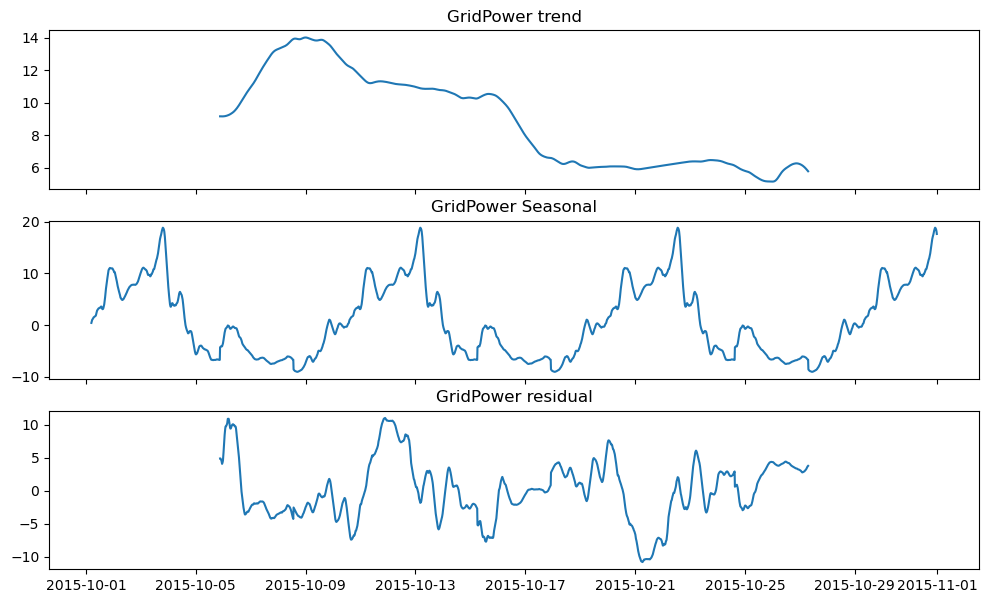

In [89]:
from statsmodels.tsa.seasonal import seasonal_decompose

## Decompose Time Series
GridPower_ma = np.array(data_df.GridPower_ma[19:])
GridPower_todecompose = pd.DataFrame(GridPower_ma,index=Date[19:])
GridPower_dec = seasonal_decompose(GridPower_todecompose,period=60*15)
GridPower_trend = GridPower_dec.trend
GridPower_seasonal = GridPower_dec.seasonal
GridPower_res = GridPower_dec.resid

plt.subplots(3,1,figsize=(12,7),sharex=True)

plt.subplot(3,1,1)
plt.plot(Date[19:], GridPower_trend)
plt.gca().set(title="GridPower trend")

plt.subplot(3,1,2)
plt.plot(Date[19:], GridPower_seasonal)
plt.gca().set(title="GridPower Seasonal")

plt.subplot(3,1,3)
plt.plot(Date[19:], GridPower_res)
plt.gca().set(title="GridPower residual")
plt.show()


同理，可以作出WindSpd的季节性分解

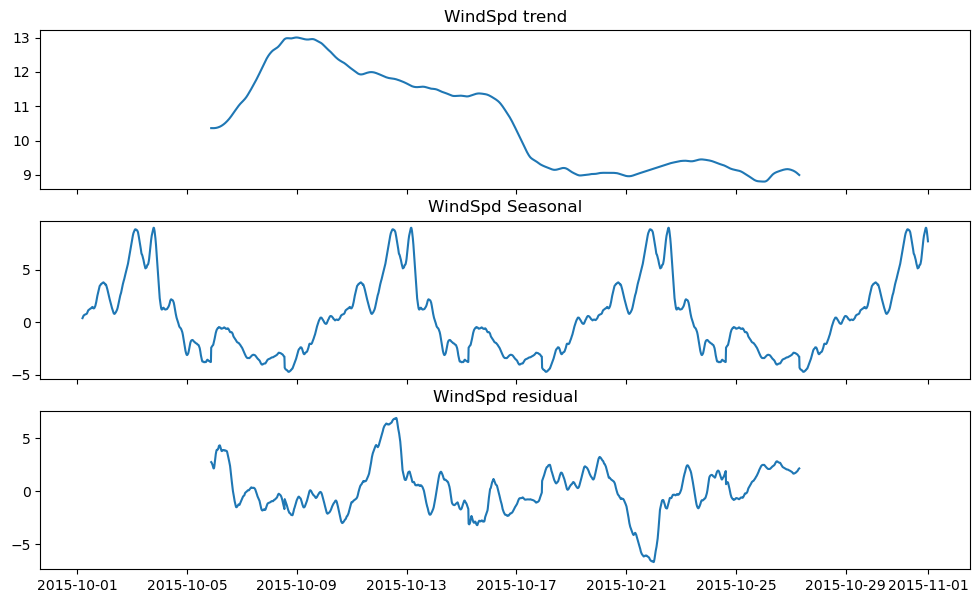

In [90]:
## Decompose Time Series
WindSpd_ma = np.array(data_df.WindSpd_ma[19:])
WindSpd_todecompose = pd.DataFrame(WindSpd_ma,index=Date[19:])
WindSpd_dec = seasonal_decompose(WindSpd_todecompose,period=60*15)
WindSpd_trend = WindSpd_dec.trend
WindSpd_seasonal = WindSpd_dec.seasonal
WindSpd_res = WindSpd_dec.resid

plt.subplots(3,1,figsize=(12,7),sharex=True)

plt.subplot(3,1,1)
plt.plot(Date[19:], WindSpd_trend)
plt.gca().set(title="WindSpd trend")

plt.subplot(3,1,2)
plt.plot(Date[19:], WindSpd_seasonal)
plt.gca().set(title="WindSpd Seasonal")

plt.subplot(3,1,3)
plt.plot(Date[19:], WindSpd_res)
plt.gca().set(title="WindSpd residual")
plt.show()

从以上分解得到的图像可以得到，二者具有相似的Seasonal的类型，说明了整体而言二者具有较为相似的特征，利用一组数据作预测是有相似性的基础。

但是实际上可以看出，做完后Trend项无明显的特征，而residual相对于其它component的大小均显著，因此实际上两组数据的季节性特征并不明显，可以说其季节性特征是较为不明显的。

## 规范化格式化存储
综合以上分析可以看出，实际上在经过分析后得到的信息并不多，相对而言，对后续分析较为有用的是填补后的数据、平滑后的数据、以及线性回归所得到的数据。因此将这些对后续分析有用的数据进行格式化存储到csv文件中。

首先将线性回归得到的模型进行预测并存储。

In [91]:
GridPower_predict = np.zeros(len(data_df.GridPower))
for i in range(len(data_df.GridPower)):
    if data_df.WindSpd[i] <= 16.5:
        GridPower_predict[i] = beta1[0]+beta1[1]*data_df.WindSpd[i]
    else:
        GridPower_predict[i] = beta2[0]+beta2[1]*data_df.WindSpd[i]

data_df["GridPower_predict"] = GridPower_predict

接下来对数据进行格式化存储。由于数据量较小，因此直接储存在对应目录下为csv文件，也方便其它软件对其进行读写。

In [92]:
data_df.to_csv("data.csv")